In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [9]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
def Conv3D_Block(inp_shape):
        inp = tf.keras.layers.Input(shape=inp_shape)

        # We will construct 3 `ConvLSTM2D` layers with batch normalization,
        # followed by a `Conv3D` layer for the spatiotemporal outputs.
        x = tf.keras.layers.ConvLSTM3D(filters=64, kernel_size=(5, 5,5), padding="same", return_sequences=True, activation="relu")(inp)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ConvLSTM3D(filters=32, kernel_size=(3, 3,3), padding="same", return_sequences=True, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        res1 = tf.keras.layers.ConvLSTM3D(filters=16, kernel_size=(1, 1,1), padding="same", return_sequences=True, activation="relu")(x)
        # attention
        x = SpatialAttention(3)(res1)
        # residual
        x = tf.keras.layers.Add()([res1, x])
        x = tf.keras.layers.Dense(64,activation='relu')(x)
        x = tf.keras.layers.Dense(32,activation='relu')(x)
        x = tf.keras.layers.Dense(16,activation='relu')(x)

        # Next, we will build the complete model and compile it.
        model = tf.keras.Model(inputs=inp, outputs=x)
        return model

In [10]:
latent_dim = 4
batch_size = 1
model1 = Conv3D_Block((batch_size, 24, 265,265,1))
model2 = Conv3D_Block((batch_size, 24, 265,265,1))
combined = tf.keras.layers.concatenate([model1.output, model2.output], axis=-1)
x = tf.keras.layers.Dense(64,'relu')(combined)
x = tf.keras.layers.Dense(32,'relu')(x)
x = tf.keras.layers.Dense(16,'relu')(x)
x = tf.keras.layers.Flatten()(x)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(inputs=[model1.input, model2.input], outputs= [z_mean, z_log_var, z], name="encoder")

In [11]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1, 24, 265,  0           []                               
                                 265, 1)]                                                         
                                                                                                  
 input_6 (InputLayer)           [(None, 1, 24, 265,  0           []                               
                                 265, 1)]                                                         
                                                                                                  
 conv_lstm3d_12 (ConvLSTM3D)    (None, 1, 24, 265,   2080256     ['input_5[0][0]']                
                                265, 64)                                                    

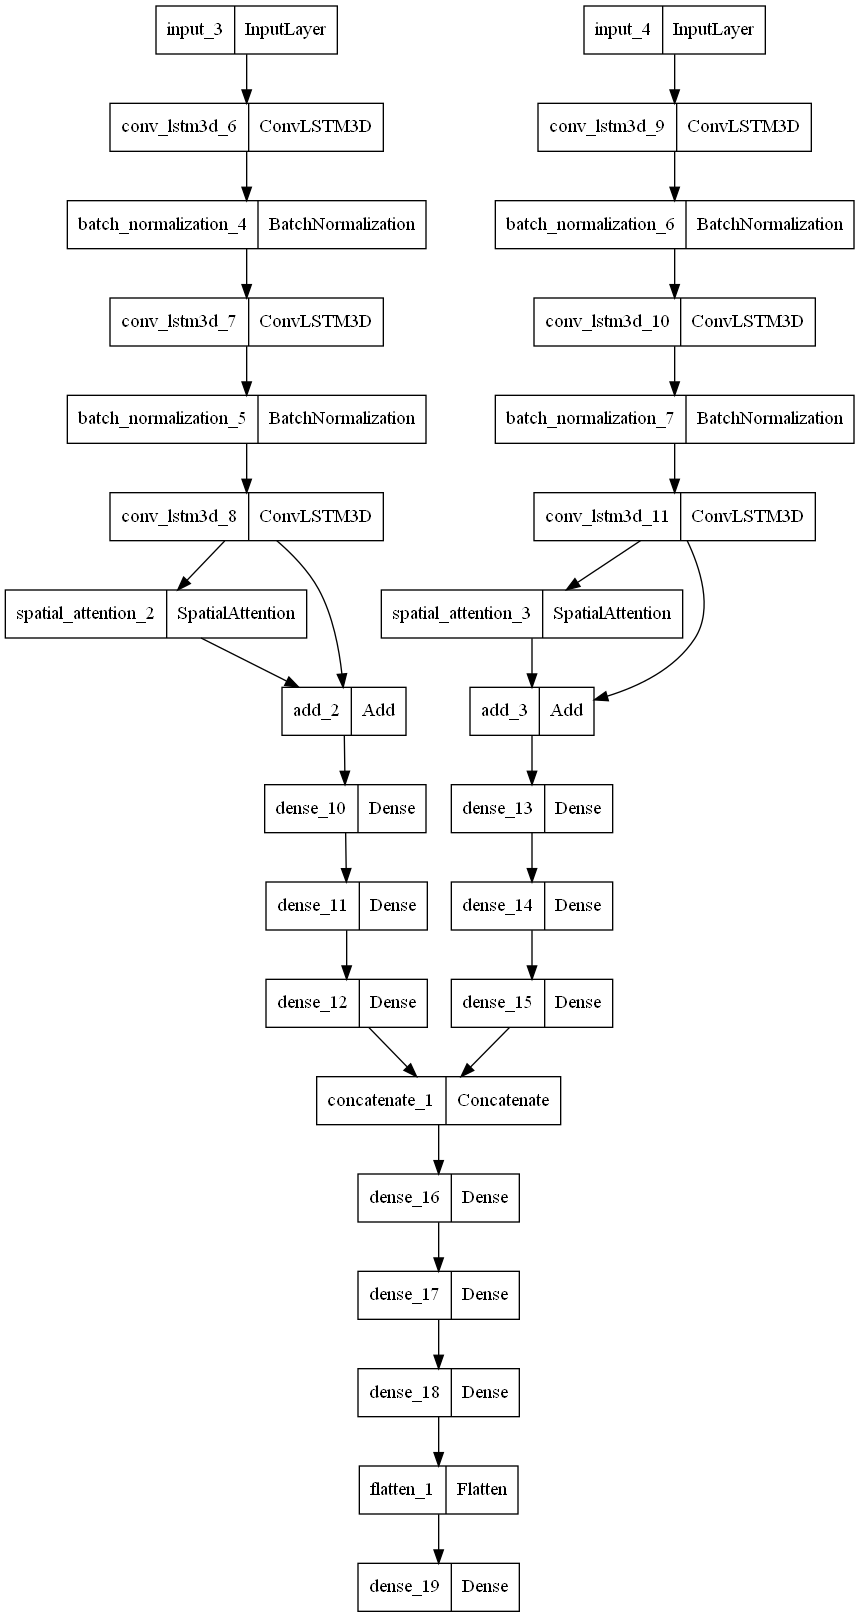

In [8]:
tf.keras.utils.plot_model(encoder, 'model.png')